# Data Extraction

## some basic indexing of the raw locust logs

In [1]:
import glob, re
from collections import OrderedDict
statsfiles = sorted(glob.glob("data/*.stats.log"))
testruns = []
for statsfile in statsfiles:
    m = re.search('/*([0-9]+)workers-([0-9]+)clients-i-[^-]*(-.*)?\..*\.log', statsfile)
    workers, clients = m.group(1, 2)
    note = ''
    try:
        note = m.group(3)[1:]
    except:
        pass
    eventsfile = re.sub('\.stats\.log', '.events.log', statsfile)
    testruns.append(OrderedDict({
            'note': note,
            'workers': int(workers),
            'clients': int(clients),
            'statsfile': statsfile,
            'eventsfile': eventsfile,
        }))

In [2]:
print('indexed {} test runs'.format(len(testruns)))

indexed 48 test runs


## extract timestamps of citical points for each test run

In [3]:
for run in testruns:
    ts_hatching_start = None
    ts_hatching_finish = None
    ts_done = None
    with open(run['eventsfile']) as events:
        for line in events:
            if "Hatching and swarming" in line:
                ts_hatching_start = re.search('^\[(.*)\]', line).group(1)
            elif "All locusts hatched" in line:
                ts_hatching_finish = re.search('^\[(.*)\]', line).group(1)
            elif "Got SIGTERM signal" in line:
                ts_done = re.search('^\[(.*)\]', line).group(1)
    run['ts_hatching_start'] = ts_hatching_start
    run['ts_hatching_finish'] = ts_hatching_finish
    run['ts_done'] = ts_done

In [4]:
from tabulate import tabulate
runs_no_files = [ OrderedDict((k, run[k]) for k in run.keys() if k not in ['eventsfile','statsfile']) for run in testruns]
print(tabulate(runs_no_files, headers='keys'))

  clients  note           workers  ts_hatching_start        ts_hatching_finish       ts_done
---------  -----------  ---------  -----------------------  -----------------------  -----------------------
      275                      20  2017-01-13 21:41:57,141  2017-01-13 21:42:08,734  2017-01-13 21:51:56,865
      330                      20  2017-01-13 21:52:17,217  2017-01-13 21:52:31,207  2017-01-13 22:02:16,942
      385                      20  2017-01-13 22:02:37,302  2017-01-13 22:02:53,973  2017-01-13 22:12:37,032
      440                      20  2017-01-13 22:12:57,387  2017-01-13 22:13:17,010  2017-01-13 22:22:57,119
      495                      20  2017-01-13 22:23:17,480  2017-01-13 22:23:40,311  2017-01-13 22:33:17,203
      550                      20  2017-01-13 22:33:37,602  2017-01-13 22:34:05,969  2017-01-13 22:43:37,334
      688                      20  2017-01-13 22:43:57,727  2017-01-13 22:44:34,320  2017-01-13 22:53:57,460
      825                      20  

## extract throughput from locust's perspective (requests per second)

In [5]:
for run in testruns:
    ts_hatching_start = None
    ts_hatching_finish = None
    ts_done = None
    with open(run['statsfile']) as events:
        lines = events.readlines()
    rps = next(l for l in reversed(lines) if ' Total' in l).split()[-1]
    run['stat_rps'] = float(rps)

# MySQL/DMS tests

In [6]:
runs_no_files = [ OrderedDict((k, run[k]) for k in run.keys() if k not in ['eventsfile','statsfile']) for run in testruns]
baseline_workers = 28
baseline_runs=[run for run in runs_no_files if run['workers'] == baseline_workers]
print(tabulate(sorted(baseline_runs, key=lambda x: x['note']), headers='keys'))

  clients  note           workers  ts_hatching_start        ts_hatching_finish       ts_done                    stat_rps
---------  -----------  ---------  -----------------------  -----------------------  -----------------------  ----------
      175                      28  2017-01-18 18:19:09,415  2017-01-18 18:19:16,739  2017-01-18 18:29:09,144       201.9
      210                      28  2017-01-18 18:29:29,476  2017-01-18 18:29:38,348  2017-01-18 18:39:29,203       246.2
      245                      28  2017-01-18 18:39:49,534  2017-01-18 18:40:00,120  2017-01-18 18:49:49,262       275.5
      280                      28  2017-01-18 18:50:09,588  2017-01-18 18:50:22,159  2017-01-18 19:00:09,311       288.6
      315                      28  2017-01-18 19:00:29,658  2017-01-18 19:00:44,422  2017-01-18 19:10:29,384       322.3
      350                      28  2017-01-18 19:10:49,737  2017-01-18 19:11:07,377  2017-01-18 19:20:49,460       335.8
      438                      2

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

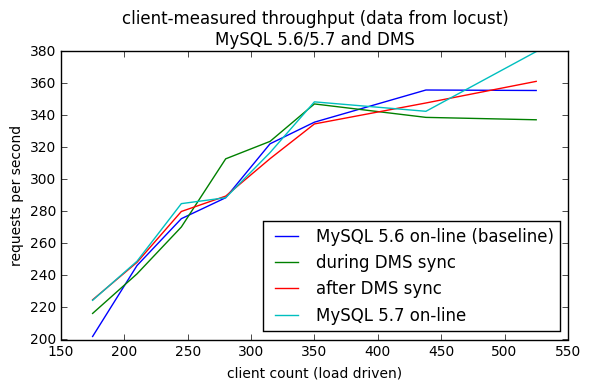

In [13]:
baseline_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == '']
during_sync_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'during_sync']
after_sync_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'after_sync']
mysql_new_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'mysql_5.7']

fig = plt.figure()

plt.title('client-measured throughput (data from locust)\nMySQL 5.6/5.7 and DMS')
plt.xlabel('client count (load driven)')
plt.ylabel('requests per second')

baseline_line, = plt.plot(np.array([float(run['clients']) for run in baseline_runs]),
                          np.array([run['stat_rps'] for run in baseline_runs]))
during_sync_line, = plt.plot(np.array([float(run['clients']) for run in during_sync_runs]),
                             np.array([run['stat_rps'] for run in during_sync_runs]))
after_sync_line, = plt.plot(np.array([float(run['clients']) for run in after_sync_runs]),
                            np.array([run['stat_rps'] for run in after_sync_runs]))
mysql_new_line, = plt.plot(np.array([float(run['clients']) for run in mysql_new_runs]),
                           np.array([run['stat_rps'] for run in mysql_new_runs]))


plt.legend((baseline_line, during_sync_line, after_sync_line, mysql_new_line), 
           ('MySQL 5.6 on-line (baseline)', 'during DMS sync', 'after DMS sync', 'MySQL 5.7 on-line'),
           loc='lower right')

fig.tight_layout()  # needed for a quirk in jupyter/matplotlib integration.
plt.savefig('results/client-measured-throughput_mysql5.6_dms_mysql5.7.png')

# Tuning gunicorn worker count (PERF-404)

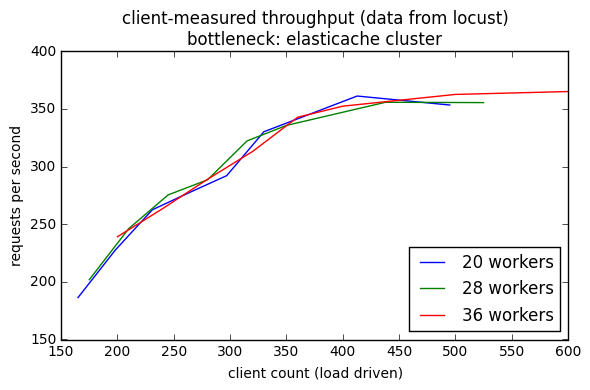

In [9]:
runs_20workers = [run for run in testruns if run['workers'] == 20]
runs_28workers = [run for run in testruns if run['workers'] == 28 and run['note'] == '']
runs_36workers = [run for run in testruns if run['workers'] == 36]

fig = plt.figure()

C = 0.6  # this is a constant multiplier for the 20-workers test runs which used a longer wait time

line_20workers, = plt.plot(np.array([C * float(run['clients']) for run in runs_20workers]),
                           np.array([run['stat_rps'] for run in runs_20workers]))
line_28workers, = plt.plot(np.array([float(run['clients']) for run in runs_28workers]),
                           np.array([run['stat_rps'] for run in runs_28workers]))
line_36workers, = plt.plot(np.array([float(run['clients']) for run in runs_36workers]),
                           np.array([run['stat_rps'] for run in runs_36workers]))

plt.legend((line_20workers, line_28workers, line_36workers), 
           ('20 workers', '28 workers', '36 workers'),
           loc='lower right')

plt.xlabel('client count (load driven)')
plt.ylabel('requests per second')
plt.title('client-measured throughput (data from locust)\nbottleneck: elasticache cluster')

fig.tight_layout()  # needed for a quirk in jupyter/matplotlib integration.
plt.savefig('results/client-measured-throughput_changing-workers_slow-elasticache.png')

In the above graph, all gunicorn worker counts resulted in the same peak throughput, but edxapp instances were still not pegged on either CPU or memory.  We discovered that one instance in the Elasticache cluster was under disproportionately high load compared to the rest, and estimated that its network throughput during the loadtest was at or above what AWS claims it can sustain (instance type in question was cache.m1.large).

We need to improve cache key distribution for the standard load tests in order to keep elasticache from 